In [4]:
try:
    import xgboost  # noqa: F401
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

if not XGB_AVAILABLE:
    try:
        # In Kaggle/Colab, this should succeed. If it fails (e.g., offline), you can skip the bonus.
        !pip -q install xgboost
        import xgboost  # noqa: F401
        XGB_AVAILABLE = True
    except Exception as e:
        print("⚠️ Could not install xgboost automatically. You can proceed without the bonus.")
        print(e)


In [5]:
import os, re, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False


In [6]:
def standardize_columns(df):
    # Lowercase; replace non-alphanum with underscore; strip repeats
    new_cols = []
    for c in df.columns:
        c2 = re.sub(r'[^0-9a-zA-Z]+', '_', c.strip().lower())
        c2 = re.sub(r'_+', '_', c2).strip('_')
        new_cols.append(c2)
    df.columns = new_cols
    return df

def auto_find_csv(search_dir='/kaggle/input'):

    if not os.path.exists(search_dir):
        return None
    patterns = ["*smoke*.csv", "*fire*.csv", "*alarm*.csv", "*iot*.csv", "*.csv"]
    for pat in patterns:
        files = glob.glob(os.path.join(search_dir, "**", pat), recursive=True)
        if files:

            files_sorted = sorted(files, key=lambda p: (0 if 'smoke' in p.lower() or 'fire' in p.lower() else 1, len(p)))
            return files_sorted[0]
    return None

DATA_PATH = auto_find_csv('/kaggle/input')
print("Auto-detected data path:", DATA_PATH)


Auto-detected data path: None


In [7]:
if DATA_PATH is None:
    try:
        from google.colab import files  # type: ignore
        print("🔼 Please choose the CSV file to upload...")
        up = files.upload()
        if up:
            DATA_PATH = list(up.keys())[0]
            print("Using uploaded file:", DATA_PATH)
    except Exception as e:
        print("Upload not available (probably not running in Colab).", e)


🔼 Please choose the CSV file to upload...


Saving archive (4).zip to archive (4).zip
Using uploaded file: archive (4).zip


In [8]:

assert DATA_PATH is not None, "❌ Dataset not found. Please add the Kaggle dataset via 'Add data' or set DATA_PATH manually."

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df = standardize_columns(df)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Shape: (62630, 16)

Columns: ['unnamed_0', 'utc', 'temperature_c', 'humidity', 'tvoc_ppb', 'eco2_ppm', 'raw_h2', 'raw_ethanol', 'pressure_hpa', 'pm1_0', 'pm2_5', 'nc0_5', 'nc1_0', 'nc2_5', 'cnt', 'fire_alarm']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unnamed_0      62630 non-null  int64  
 1   utc            62630 non-null  int64  
 2   temperature_c  62630 non-null  float64
 3   humidity       62630 non-null  float64
 4   tvoc_ppb       62630 non-null  int64  
 5   eco2_ppm       62630 non-null  int64  
 6   raw_h2         62630 non-null  int64  
 7   raw_ethanol    62630 non-null  int64  
 8   pressure_hpa   62630 non-null  float64
 9   pm1_0          62630 non-null  float64
 10  pm2_5          62630 non-null  float64
 11  nc0_5          62630 non-null  float64
 12  nc1_0          62630 non-null  float64
 13  nc2_5    

In [9]:
candidate_targets = [
    'fire_alarm', 'alarm', 'fire', 'target', 'class', 'label', 'smoke_detected'
]

target_col = None
for c in candidate_targets:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    raise ValueError(
        "❌ Could not auto-detect target column. "
        "Please set 'target_col' manually from df.columns."
    )

print(f"Detected target column: {target_col}")

if df[target_col].dtype == 'O':

    mapping = {'yes':1, 'y':1, 'true':1, 'on':1, 'fire':1,
               'no':0, 'n':0, 'false':0, 'off':0, 'normal':0}
    df[target_col] = df[target_col].astype(str).str.strip().str.lower().map(mapping).astype('Int64')
    if df[target_col].isna().any():

        df[target_col] = pd.factorize(df[target_col].astype(str))[0]
else:

    unique_vals = sorted(df[target_col].dropna().unique())
    if not set(unique_vals).issubset({0,1}):
        df[target_col] = (df[target_col] > 0).astype(int)

drop_like = ['id', 'index', 'timestamp', 'time', 'date']
to_drop = [c for c in df.columns if any(k in c for k in drop_like) and c != target_col]

features = [c for c in df.columns if c != target_col and c not in to_drop]
X = df[features].copy()
y = df[target_col].astype(int).copy()

print(f"Using {len(features)} features. Dropped: {to_drop}")


Detected target column: fire_alarm
Using 14 features. Dropped: ['humidity']


In [10]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

print("Train shape:", X_train_imp.shape, "Test shape:", X_test_imp.shape)


Train shape: (50104, 14) Test shape: (12526, 14)


=== Logistic Regression Metrics ===
Accuracy: 0.9796
Precision: 0.9895
Recall: 0.9818
F1-Score: 0.9856


<Figure size 640x480 with 0 Axes>

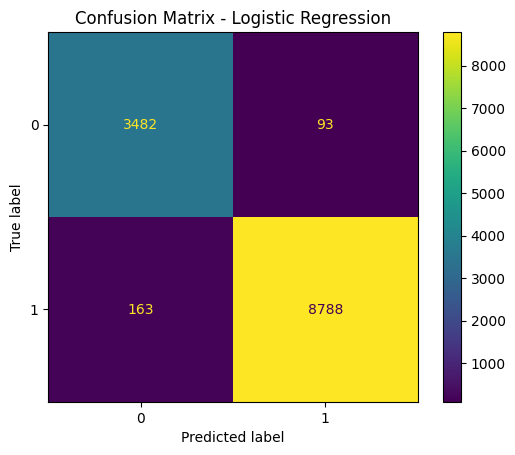

In [11]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=RANDOM_STATE))
])

lr_pipe.fit(X_train_imp, y_train)
y_pred_lr = lr_pipe.predict(X_test_imp)
y_prob_lr = lr_pipe.predict_proba(X_test_imp)[:,1]

metrics_lr = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'Recall': recall_score(y_test, y_pred_lr, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_lr, zero_division=0)
}
print("=== Logistic Regression Metrics ===")
for k,v in metrics_lr.items():
    print(f"{k}: {v:.4f}")

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig = plt.figure()
disp.plot(values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


=== XGBoost Metrics ===
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9999
F1-Score: 0.9999


<Figure size 640x480 with 0 Axes>

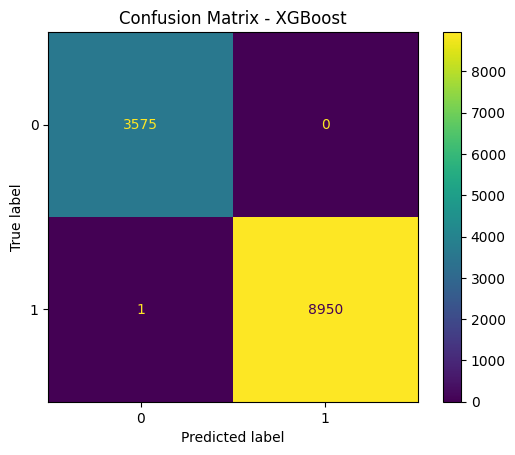

In [13]:
metrics_xgb = None
if XGB_AVAILABLE:
    xgb = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=1,
        eval_metric="logloss"
    )

    xgb.fit(X_train_imp, y_train)
    y_pred_xgb = xgb.predict(X_test_imp)
    y_prob_xgb = xgb.predict_proba(X_test_imp)[:,1]

    metrics_xgb = {
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb, zero_division=0),
        'Recall': recall_score(y_test, y_pred_xgb, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_xgb, zero_division=0)
    }
    print("=== XGBoost Metrics ===")
    for k,v in metrics_xgb.items():
        print(f"{k}: {v:.4f}")

    cm2 = confusion_matrix(y_test, y_pred_xgb)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
    fig = plt.figure()
    disp2.plot(values_format='d')
    plt.title("Confusion Matrix - XGBoost")
    plt.show()
else:
    print("⚠️ XGBoost not available. Skip bonus or install it in the first cell.")


In [14]:
rows = []
rows.append({'Model':'LogReg', **metrics_lr})
if metrics_xgb is not None:
    rows.append({'Model':'XGBoost', **metrics_xgb})

results_df = pd.DataFrame(rows).set_index('Model')
display(results_df.style.format("{:.4f}"))

best_model_by_recall = results_df['Recall'].idxmax()
print(f"Highest Recall: {best_model_by_recall} ({results_df.loc[best_model_by_recall, 'Recall']:.4f})")

from IPython.display import Markdown, display as md_display
analysis = f'''
### Discussion
- **Recall** focuses on catching as many *actual fires* as possible.
- In fire detection, **False Negatives** (missed fires) are dangerous and must be minimized.
- **Logistic Regression**: simple, fast, and interpretable — a solid baseline.
- **XGBoost**: often achieves higher performance (including recall) but is more complex and heavier.
- Based on the table above, the model with higher recall here is **{best_model_by_recall}**.
'''
md_display(Markdown(analysis))


,Accuracy,Precision,Recall,F1-Score
Model,,,,
LogReg,0.9796,0.9895,0.9818,0.9856
XGBoost,0.9999,1.0000,0.9999,0.9999


Highest Recall: XGBoost (0.9999)



### Discussion
- **Recall** focuses on catching as many *actual fires* as possible.  
- In fire detection, **False Negatives** (missed fires) are dangerous and must be minimized.
- **Logistic Regression**: simple, fast, and interpretable — a solid baseline.  
- **XGBoost**: often achieves higher performance (including recall) but is more complex and heavier.
- Based on the table above, the model with higher recall here is **XGBoost**.


In [15]:
os.makedirs("outputs", exist_ok=True)
results_path = os.path.join("outputs", "metrics_comparison.csv")
results_df.to_csv(results_path)
print("Saved metrics to:", results_path)


Saved metrics to: outputs/metrics_comparison.csv
